## a. (i) Vanilla RNN

In [7]:
histories = {}

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt
import time

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [9]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_vanilla'] = history

Epoch 1, Loss: 2.701474189758301, Accuracy: 0.06892856955528259, Test Loss: 2.6480143070220947, Test Accuracy: 0.10571428388357162
Epoch 2, Loss: 2.640561103820801, Accuracy: 0.08964285999536514, Test Loss: 2.6209232807159424, Test Accuracy: 0.1014285683631897
Epoch 3, Loss: 2.6282336711883545, Accuracy: 0.09517857432365417, Test Loss: 2.6149251461029053, Test Accuracy: 0.09285714477300644
Epoch 4, Loss: 2.65195631980896, Accuracy: 0.10607142746448517, Test Loss: 2.6753580570220947, Test Accuracy: 0.07428571581840515
Epoch 5, Loss: 2.638478994369507, Accuracy: 0.08964285999536514, Test Loss: 2.6195409297943115, Test Accuracy: 0.08142857253551483
Epoch 6, Loss: 2.6124773025512695, Accuracy: 0.10464286059141159, Test Loss: 2.6115732192993164, Test Accuracy: 0.09285714477300644
Epoch 7, Loss: 2.598510503768921, Accuracy: 0.11589285731315613, Test Loss: 2.604677200317383, Test Accuracy: 0.09571428596973419
Epoch 8, Loss: 2.6078357696533203, Accuracy: 0.10946428775787354, Test Loss: 2.61514

Epoch 64, Loss: 2.6332530975341797, Accuracy: 0.08839285373687744, Test Loss: 2.618593454360962, Test Accuracy: 0.09714286029338837
Epoch 65, Loss: 2.6338119506835938, Accuracy: 0.08946428447961807, Test Loss: 2.6200382709503174, Test Accuracy: 0.09857142716646194
Epoch 66, Loss: 2.623717784881592, Accuracy: 0.09446428716182709, Test Loss: 2.606743097305298, Test Accuracy: 0.1071428582072258
Epoch 67, Loss: 2.6203227043151855, Accuracy: 0.09678571671247482, Test Loss: 2.627168655395508, Test Accuracy: 0.08285713940858841
Epoch 68, Loss: 2.6285765171051025, Accuracy: 0.09392856806516647, Test Loss: 2.6204235553741455, Test Accuracy: 0.10285714268684387
Epoch 69, Loss: 2.615959644317627, Accuracy: 0.09446428716182709, Test Loss: 2.620422124862671, Test Accuracy: 0.09142857044935226
Epoch 70, Loss: 2.621962547302246, Accuracy: 0.10035714507102966, Test Loss: 2.618824005126953, Test Accuracy: 0.10428571701049805
Epoch 71, Loss: 2.622164011001587, Accuracy: 0.09910714626312256, Test Loss: 2

Epoch 126, Loss: 2.65647292137146, Accuracy: 0.07357142865657806, Test Loss: 2.6453676223754883, Test Accuracy: 0.08428571373224258
Epoch 127, Loss: 2.6529746055603027, Accuracy: 0.07999999821186066, Test Loss: 2.638404369354248, Test Accuracy: 0.06857142597436905
Epoch 128, Loss: 2.645305871963501, Accuracy: 0.08196428418159485, Test Loss: 2.6371371746063232, Test Accuracy: 0.07285714149475098
Epoch 129, Loss: 2.646592617034912, Accuracy: 0.0803571417927742, Test Loss: 2.6342694759368896, Test Accuracy: 0.07428571581840515
Epoch 130, Loss: 2.6460559368133545, Accuracy: 0.08017857372760773, Test Loss: 2.641423225402832, Test Accuracy: 0.07999999821186066
Epoch 131, Loss: 2.645994186401367, Accuracy: 0.0867857113480568, Test Loss: 2.6358895301818848, Test Accuracy: 0.0771428570151329
Epoch 132, Loss: 2.6469576358795166, Accuracy: 0.08142857253551483, Test Loss: 2.639794111251831, Test Accuracy: 0.09142857044935226
Epoch 133, Loss: 2.6464180946350098, Accuracy: 0.08071428537368774, Test 

Epoch 188, Loss: 2.6322412490844727, Accuracy: 0.08446428924798965, Test Loss: 2.6329262256622314, Test Accuracy: 0.08428571373224258
Epoch 189, Loss: 2.6390886306762695, Accuracy: 0.08553571254014969, Test Loss: 2.6204769611358643, Test Accuracy: 0.09000000357627869
Epoch 190, Loss: 2.6353185176849365, Accuracy: 0.08821428567171097, Test Loss: 2.5992581844329834, Test Accuracy: 0.1071428582072258
Epoch 191, Loss: 2.6245546340942383, Accuracy: 0.09660714119672775, Test Loss: 2.61220121383667, Test Accuracy: 0.09285714477300644
Epoch 192, Loss: 2.6336634159088135, Accuracy: 0.08142857253551483, Test Loss: 2.611900806427002, Test Accuracy: 0.1071428582072258
Epoch 193, Loss: 2.6323118209838867, Accuracy: 0.09107142686843872, Test Loss: 2.610813856124878, Test Accuracy: 0.09714286029338837
Epoch 194, Loss: 2.623387336730957, Accuracy: 0.08982142806053162, Test Loss: 2.6104607582092285, Test Accuracy: 0.09714286029338837
Epoch 195, Loss: 2.6171765327453613, Accuracy: 0.10125000029802322, T

Epoch 250, Loss: 2.6457817554473877, Accuracy: 0.08428571373224258, Test Loss: 2.6338894367218018, Test Accuracy: 0.0771428570151329


## a. (ii) LSTM

In [10]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_LSTM'] = history

Epoch 1, Loss: 2.667398691177368, Accuracy: 0.08178571611642838, Test Loss: 2.6036479473114014, Test Accuracy: 0.11142857372760773
Epoch 2, Loss: 2.6265573501586914, Accuracy: 0.0982142835855484, Test Loss: 2.587406873703003, Test Accuracy: 0.11857143044471741
Epoch 3, Loss: 2.552295446395874, Accuracy: 0.11660714447498322, Test Loss: 2.463139772415161, Test Accuracy: 0.14000000059604645
Epoch 4, Loss: 2.4568135738372803, Accuracy: 0.14249999821186066, Test Loss: 2.429232358932495, Test Accuracy: 0.17571428418159485
Epoch 5, Loss: 2.4983136653900146, Accuracy: 0.13607142865657806, Test Loss: 2.454545259475708, Test Accuracy: 0.14142857491970062
Epoch 6, Loss: 2.5518646240234375, Accuracy: 0.1217857152223587, Test Loss: 2.6122548580169678, Test Accuracy: 0.11142857372760773
Epoch 7, Loss: 2.6056954860687256, Accuracy: 0.10696428269147873, Test Loss: 2.5876007080078125, Test Accuracy: 0.11428571492433548
Epoch 8, Loss: 2.5762908458709717, Accuracy: 0.1319642812013626, Test Loss: 2.537610

Epoch 64, Loss: 1.0278574228286743, Accuracy: 0.6030356884002686, Test Loss: 1.2087516784667969, Test Accuracy: 0.6071428656578064
Epoch 65, Loss: 1.0250188112258911, Accuracy: 0.6069642901420593, Test Loss: 1.1835767030715942, Test Accuracy: 0.604285717010498
Epoch 66, Loss: 1.0139821767807007, Accuracy: 0.6073214411735535, Test Loss: 1.1996197700500488, Test Accuracy: 0.6271428465843201
Epoch 67, Loss: 1.0030341148376465, Accuracy: 0.6067857146263123, Test Loss: 1.1592544317245483, Test Accuracy: 0.6128571629524231
Epoch 68, Loss: 1.0000649690628052, Accuracy: 0.6101785898208618, Test Loss: 1.2019528150558472, Test Accuracy: 0.6071428656578064
Epoch 69, Loss: 1.0141968727111816, Accuracy: 0.6142857074737549, Test Loss: 1.1442798376083374, Test Accuracy: 0.6085714101791382
Epoch 70, Loss: 1.0126572847366333, Accuracy: 0.6080357432365417, Test Loss: 1.2428478002548218, Test Accuracy: 0.6100000143051147
Epoch 71, Loss: 1.0150017738342285, Accuracy: 0.6114285588264465, Test Loss: 1.14137

Epoch 127, Loss: 0.9300066232681274, Accuracy: 0.6519643068313599, Test Loss: 1.2417237758636475, Test Accuracy: 0.5971428751945496
Epoch 128, Loss: 0.9408106207847595, Accuracy: 0.643750011920929, Test Loss: 1.2056465148925781, Test Accuracy: 0.6485714316368103
Epoch 129, Loss: 0.8254638910293579, Accuracy: 0.6773214340209961, Test Loss: 1.2461423873901367, Test Accuracy: 0.6428571343421936
Epoch 130, Loss: 0.8954171538352966, Accuracy: 0.6680356860160828, Test Loss: 1.1370595693588257, Test Accuracy: 0.6557142734527588
Epoch 131, Loss: 0.815608024597168, Accuracy: 0.6892856955528259, Test Loss: 1.1890615224838257, Test Accuracy: 0.654285728931427
Epoch 132, Loss: 0.8023974895477295, Accuracy: 0.695892870426178, Test Loss: 1.1995679140090942, Test Accuracy: 0.6657142639160156
Epoch 133, Loss: 0.7742252349853516, Accuracy: 0.7005357146263123, Test Loss: 1.2374690771102905, Test Accuracy: 0.6571428775787354
Epoch 134, Loss: 0.7766382098197937, Accuracy: 0.7035714387893677, Test Loss: 1.

Epoch 190, Loss: 0.7284536361694336, Accuracy: 0.729285717010498, Test Loss: 1.1746412515640259, Test Accuracy: 0.691428542137146
Epoch 191, Loss: 0.753366231918335, Accuracy: 0.7200000286102295, Test Loss: 1.1924070119857788, Test Accuracy: 0.6928571462631226
Epoch 192, Loss: 0.7122382521629333, Accuracy: 0.7408928275108337, Test Loss: 1.1919631958007812, Test Accuracy: 0.6942856907844543
Epoch 193, Loss: 0.7152225971221924, Accuracy: 0.739642858505249, Test Loss: 1.2592997550964355, Test Accuracy: 0.6957142949104309
Epoch 194, Loss: 0.6884082555770874, Accuracy: 0.7455357313156128, Test Loss: 1.221323013305664, Test Accuracy: 0.6857143044471741
Epoch 195, Loss: 0.6816809773445129, Accuracy: 0.7482143044471741, Test Loss: 1.2997444868087769, Test Accuracy: 0.699999988079071
Epoch 196, Loss: 0.6780533194541931, Accuracy: 0.7537500262260437, Test Loss: 1.2946537733078003, Test Accuracy: 0.7028571367263794
Epoch 197, Loss: 0.6948819160461426, Accuracy: 0.751964271068573, Test Loss: 1.350

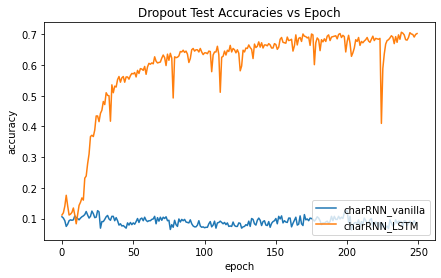

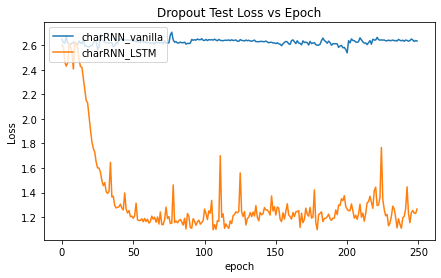

In [12]:
plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_vanilla']['test_acc'])
plt.plot(histories['charRNN_LSTM']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['charRNN_vanilla','charRNN_LSTM'], loc='lower right')

plt.savefig(
    f'./results/partB_qn6_charRNN_0.5_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_vanilla']['test_loss'])
plt.plot(histories['charRNN_LSTM']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['charRNN_vanilla','charRNN_LSTM'], loc='upper left')

plt.savefig(
    f'./results/partB_qn6_charRNN_0.5_loss.pdf'
)

## a. (i) Vanilla RNN SGD

In [13]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_vanilla_SGD'] = history

Epoch 1, Loss: 2.74849796295166, Accuracy: 0.07374999672174454, Test Loss: 2.736345052719116, Test Accuracy: 0.058571428060531616
Epoch 2, Loss: 2.746168613433838, Accuracy: 0.07196428626775742, Test Loss: 2.7296130657196045, Test Accuracy: 0.058571428060531616
Epoch 3, Loss: 2.7361397743225098, Accuracy: 0.06642857193946838, Test Loss: 2.7241218090057373, Test Accuracy: 0.0657142847776413
Epoch 4, Loss: 2.7205283641815186, Accuracy: 0.0816071406006813, Test Loss: 2.719435691833496, Test Accuracy: 0.07285714149475098
Epoch 5, Loss: 2.7216691970825195, Accuracy: 0.07535714656114578, Test Loss: 2.7151734828948975, Test Accuracy: 0.07000000029802322
Epoch 6, Loss: 2.7138593196868896, Accuracy: 0.0758928582072258, Test Loss: 2.7115278244018555, Test Accuracy: 0.0771428570151329
Epoch 7, Loss: 2.7122716903686523, Accuracy: 0.07660714536905289, Test Loss: 2.7081987857818604, Test Accuracy: 0.07571428269147873
Epoch 8, Loss: 2.7053041458129883, Accuracy: 0.0746428593993187, Test Loss: 2.70523

Epoch 64, Loss: 2.6285488605499268, Accuracy: 0.10482142865657806, Test Loss: 2.6299197673797607, Test Accuracy: 0.09714286029338837
Epoch 65, Loss: 2.632737159729004, Accuracy: 0.09767857193946838, Test Loss: 2.623018980026245, Test Accuracy: 0.10285714268684387
Epoch 66, Loss: 2.6264021396636963, Accuracy: 0.10482142865657806, Test Loss: 2.636434555053711, Test Accuracy: 0.07999999821186066
Epoch 67, Loss: 2.6313929557800293, Accuracy: 0.09785714000463486, Test Loss: 2.622002601623535, Test Accuracy: 0.10428571701049805
Epoch 68, Loss: 2.629744291305542, Accuracy: 0.10232143104076385, Test Loss: 2.6253061294555664, Test Accuracy: 0.09285714477300644
Epoch 69, Loss: 2.6319079399108887, Accuracy: 0.09678571671247482, Test Loss: 2.626249074935913, Test Accuracy: 0.08571428805589676
Epoch 70, Loss: 2.624305248260498, Accuracy: 0.11071428656578064, Test Loss: 2.6456775665283203, Test Accuracy: 0.08142857253551483
Epoch 71, Loss: 2.62264084815979, Accuracy: 0.10821428894996643, Test Loss: 

Epoch 126, Loss: 2.5896100997924805, Accuracy: 0.11392857134342194, Test Loss: 2.5856058597564697, Test Accuracy: 0.11142857372760773
Epoch 127, Loss: 2.582373857498169, Accuracy: 0.13160714507102966, Test Loss: 2.571873903274536, Test Accuracy: 0.10857142508029938
Epoch 128, Loss: 2.579019784927368, Accuracy: 0.12196428328752518, Test Loss: 2.6027932167053223, Test Accuracy: 0.10285714268684387
Epoch 129, Loss: 2.588301658630371, Accuracy: 0.12089285999536514, Test Loss: 2.5812814235687256, Test Accuracy: 0.1128571406006813
Epoch 130, Loss: 2.5769479274749756, Accuracy: 0.1257142871618271, Test Loss: 2.576712131500244, Test Accuracy: 0.10999999940395355
Epoch 131, Loss: 2.5799245834350586, Accuracy: 0.12464285641908646, Test Loss: 2.619988203048706, Test Accuracy: 0.10571428388357162
Epoch 132, Loss: 2.586306095123291, Accuracy: 0.12553571164608002, Test Loss: 2.5697879791259766, Test Accuracy: 0.11857143044471741
Epoch 133, Loss: 2.585073471069336, Accuracy: 0.12482143193483353, Test

Epoch 189, Loss: 2.5555312633514404, Accuracy: 0.14053571224212646, Test Loss: 2.5714807510375977, Test Accuracy: 0.11142857372760773
Epoch 190, Loss: 2.559941053390503, Accuracy: 0.13785713911056519, Test Loss: 2.5825035572052, Test Accuracy: 0.11428571492433548
Epoch 191, Loss: 2.548673629760742, Accuracy: 0.13660714030265808, Test Loss: 2.542433023452759, Test Accuracy: 0.14000000059604645
Epoch 192, Loss: 2.5514485836029053, Accuracy: 0.13696429133415222, Test Loss: 2.5464985370635986, Test Accuracy: 0.13428571820259094
Epoch 193, Loss: 2.5617034435272217, Accuracy: 0.13607142865657806, Test Loss: 2.5706071853637695, Test Accuracy: 0.12285714596509933
Epoch 194, Loss: 2.5448038578033447, Accuracy: 0.13946428894996643, Test Loss: 2.565812826156616, Test Accuracy: 0.11999999731779099
Epoch 195, Loss: 2.5515739917755127, Accuracy: 0.13696429133415222, Test Loss: 2.5409512519836426, Test Accuracy: 0.12999999523162842
Epoch 196, Loss: 2.559631586074829, Accuracy: 0.1396428644657135, Tes

## a. (ii) LSTM SGD CharRNN

In [14]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_LSTM_SGD'] = history

Epoch 1, Loss: 2.706211566925049, Accuracy: 0.06607142835855484, Test Loss: 2.7020790576934814, Test Accuracy: 0.06714285910129547
Epoch 2, Loss: 2.7017822265625, Accuracy: 0.06964285671710968, Test Loss: 2.6974503993988037, Test Accuracy: 0.05999999865889549
Epoch 3, Loss: 2.6979405879974365, Accuracy: 0.07160714268684387, Test Loss: 2.693861722946167, Test Accuracy: 0.06142857298254967
Epoch 4, Loss: 2.694005012512207, Accuracy: 0.07089285552501678, Test Loss: 2.6907379627227783, Test Accuracy: 0.06428571790456772
Epoch 5, Loss: 2.6911492347717285, Accuracy: 0.06785714626312256, Test Loss: 2.6880757808685303, Test Accuracy: 0.0657142847776413
Epoch 6, Loss: 2.690312623977661, Accuracy: 0.07178571075201035, Test Loss: 2.6857917308807373, Test Accuracy: 0.06428571790456772
Epoch 7, Loss: 2.6870057582855225, Accuracy: 0.07107143104076385, Test Loss: 2.68367075920105, Test Accuracy: 0.06428571790456772
Epoch 8, Loss: 2.6853556632995605, Accuracy: 0.07249999791383743, Test Loss: 2.6816780

Epoch 64, Loss: 2.646746873855591, Accuracy: 0.08785714209079742, Test Loss: 2.641176700592041, Test Accuracy: 0.1014285683631897
Epoch 65, Loss: 2.646754264831543, Accuracy: 0.08571428805589676, Test Loss: 2.6407694816589355, Test Accuracy: 0.10000000149011612
Epoch 66, Loss: 2.649886131286621, Accuracy: 0.08214285969734192, Test Loss: 2.640584945678711, Test Accuracy: 0.09857142716646194
Epoch 67, Loss: 2.646775245666504, Accuracy: 0.08517856895923615, Test Loss: 2.6400692462921143, Test Accuracy: 0.1014285683631897
Epoch 68, Loss: 2.6453614234924316, Accuracy: 0.08303571492433548, Test Loss: 2.6395750045776367, Test Accuracy: 0.10000000149011612
Epoch 69, Loss: 2.6437509059906006, Accuracy: 0.09017857164144516, Test Loss: 2.6390695571899414, Test Accuracy: 0.10428571701049805
Epoch 70, Loss: 2.643073081970215, Accuracy: 0.09178571403026581, Test Loss: 2.638533592224121, Test Accuracy: 0.1071428582072258
Epoch 71, Loss: 2.6450908184051514, Accuracy: 0.08785714209079742, Test Loss: 2.

Epoch 127, Loss: 2.6206626892089844, Accuracy: 0.09285714477300644, Test Loss: 2.6163113117218018, Test Accuracy: 0.09571428596973419
Epoch 128, Loss: 2.62546968460083, Accuracy: 0.09089285880327225, Test Loss: 2.615781545639038, Test Accuracy: 0.1014285683631897
Epoch 129, Loss: 2.6208274364471436, Accuracy: 0.09071428328752518, Test Loss: 2.614885091781616, Test Accuracy: 0.09571428596973419
Epoch 130, Loss: 2.622924327850342, Accuracy: 0.10000000149011612, Test Loss: 2.6138651371002197, Test Accuracy: 0.09428571164608002
Epoch 131, Loss: 2.6189815998077393, Accuracy: 0.09714286029338837, Test Loss: 2.6120128631591797, Test Accuracy: 0.09285714477300644
Epoch 132, Loss: 2.6184022426605225, Accuracy: 0.10178571194410324, Test Loss: 2.6098968982696533, Test Accuracy: 0.09142857044935226
Epoch 133, Loss: 2.6150269508361816, Accuracy: 0.10000000149011612, Test Loss: 2.607602596282959, Test Accuracy: 0.09285714477300644
Epoch 134, Loss: 2.611833095550537, Accuracy: 0.10017856955528259, Te

Epoch 189, Loss: 2.558157444000244, Accuracy: 0.12357142567634583, Test Loss: 2.5417490005493164, Test Accuracy: 0.13857142627239227
Epoch 190, Loss: 2.5492594242095947, Accuracy: 0.12321428209543228, Test Loss: 2.543287754058838, Test Accuracy: 0.1371428519487381
Epoch 191, Loss: 2.5616700649261475, Accuracy: 0.1160714253783226, Test Loss: 2.5375983715057373, Test Accuracy: 0.1428571492433548
Epoch 192, Loss: 2.558098077774048, Accuracy: 0.12535713613033295, Test Loss: 2.5484399795532227, Test Accuracy: 0.13428571820259094
Epoch 193, Loss: 2.5511231422424316, Accuracy: 0.12160713970661163, Test Loss: 2.5385806560516357, Test Accuracy: 0.14000000059604645
Epoch 194, Loss: 2.553797721862793, Accuracy: 0.11392857134342194, Test Loss: 2.5478594303131104, Test Accuracy: 0.1428571492433548
Epoch 195, Loss: 2.5526483058929443, Accuracy: 0.12232142686843872, Test Loss: 2.5418953895568848, Test Accuracy: 0.1428571492433548
Epoch 196, Loss: 2.546761989593506, Accuracy: 0.1269642859697342, Test 

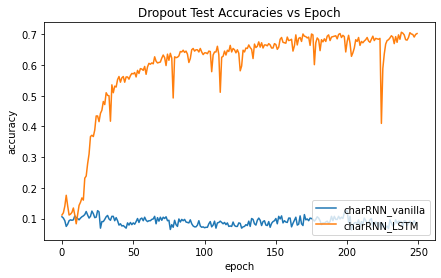

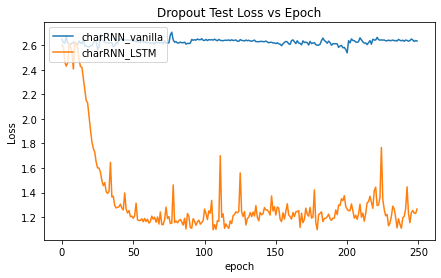

In [15]:
plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_vanilla']['test_acc'])
plt.plot(histories['charRNN_LSTM']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['charRNN_vanilla','charRNN_LSTM'], loc='lower right')

plt.savefig(
    f'./results/partB_qn6_charRNN_0.5_SGD_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_vanilla']['test_loss'])
plt.plot(histories['charRNN_LSTM']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['charRNN_vanilla','charRNN_LSTM'], loc='upper left')

plt.savefig(
    f'./results/partB_qn6_charRNN_0.5_SGD_loss.pdf'
)

## a. wordRNN Vanilla and LSTM

In [2]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk

nltk.download('punkt')

MAX_DOCUMENT_LENGTH = 100
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)


def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[nltk_data] Downloading package punkt to C:\Users\Shearman
[nltk_data]     Chua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## a. (i) Vanilla Word RNN

In [18]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_vanilla_Adam'] = history

Epoch 1, Loss: 2.692913055419922, Accuracy: 0.06928571313619614, Test Loss: 2.654207944869995, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.657708168029785, Accuracy: 0.07160714268684387, Test Loss: 2.6474320888519287, Test Accuracy: 0.06714285910129547
Epoch 3, Loss: 2.6630098819732666, Accuracy: 0.07160714268684387, Test Loss: 2.6451833248138428, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6515729427337646, Accuracy: 0.07482142746448517, Test Loss: 2.643120050430298, Test Accuracy: 0.06857142597436905
Epoch 5, Loss: 2.6465959548950195, Accuracy: 0.06875000149011612, Test Loss: 2.641756057739258, Test Accuracy: 0.07857143133878708
Epoch 6, Loss: 2.647094964981079, Accuracy: 0.06928571313619614, Test Loss: 2.6426591873168945, Test Accuracy: 0.0657142847776413
Epoch 7, Loss: 2.6426608562469482, Accuracy: 0.07857143133878708, Test Loss: 2.6427624225616455, Test Accuracy: 0.07285714149475098
Epoch 8, Loss: 2.6448400020599365, Accuracy: 0.07339286059141159, Test Loss: 2.640243

Epoch 64, Loss: 2.6386659145355225, Accuracy: 0.07678571343421936, Test Loss: 2.6400351524353027, Test Accuracy: 0.0657142847776413
Epoch 65, Loss: 2.6377320289611816, Accuracy: 0.07482142746448517, Test Loss: 2.6397321224212646, Test Accuracy: 0.0714285746216774
Epoch 66, Loss: 2.6378707885742188, Accuracy: 0.0714285746216774, Test Loss: 2.6404712200164795, Test Accuracy: 0.06857142597436905
Epoch 67, Loss: 2.6404221057891846, Accuracy: 0.07160714268684387, Test Loss: 2.639803647994995, Test Accuracy: 0.07285714149475098
Epoch 68, Loss: 2.6382687091827393, Accuracy: 0.07339286059141159, Test Loss: 2.641052007675171, Test Accuracy: 0.07285714149475098
Epoch 69, Loss: 2.6371238231658936, Accuracy: 0.07374999672174454, Test Loss: 2.640123128890991, Test Accuracy: 0.07285714149475098
Epoch 70, Loss: 2.6371748447418213, Accuracy: 0.07071428745985031, Test Loss: 2.6391170024871826, Test Accuracy: 0.07428571581840515
Epoch 71, Loss: 2.6370606422424316, Accuracy: 0.07053571194410324, Test Los

Epoch 127, Loss: 2.638129711151123, Accuracy: 0.0669642835855484, Test Loss: 2.6439735889434814, Test Accuracy: 0.06857142597436905
Epoch 128, Loss: 2.636655330657959, Accuracy: 0.08053571730852127, Test Loss: 2.642092704772949, Test Accuracy: 0.07285714149475098
Epoch 129, Loss: 2.6386072635650635, Accuracy: 0.07000000029802322, Test Loss: 2.642143964767456, Test Accuracy: 0.08285713940858841
Epoch 130, Loss: 2.637356758117676, Accuracy: 0.06875000149011612, Test Loss: 2.6414072513580322, Test Accuracy: 0.07000000029802322
Epoch 131, Loss: 2.6371471881866455, Accuracy: 0.06892856955528259, Test Loss: 2.640981912612915, Test Accuracy: 0.07000000029802322
Epoch 132, Loss: 2.637073516845703, Accuracy: 0.07000000029802322, Test Loss: 2.641333818435669, Test Accuracy: 0.07285714149475098
Epoch 133, Loss: 2.6367440223693848, Accuracy: 0.06410714238882065, Test Loss: 2.6417949199676514, Test Accuracy: 0.0714285746216774
Epoch 134, Loss: 2.6374082565307617, Accuracy: 0.07000000029802322, Test

Epoch 189, Loss: 2.636064052581787, Accuracy: 0.07196428626775742, Test Loss: 2.642913818359375, Test Accuracy: 0.06428571790456772
Epoch 190, Loss: 2.63655161857605, Accuracy: 0.07357142865657806, Test Loss: 2.6431283950805664, Test Accuracy: 0.06714285910129547
Epoch 191, Loss: 2.633965492248535, Accuracy: 0.07249999791383743, Test Loss: 2.645289659500122, Test Accuracy: 0.07999999821186066
Epoch 192, Loss: 2.634885311126709, Accuracy: 0.06517857313156128, Test Loss: 2.6434338092803955, Test Accuracy: 0.06857142597436905
Epoch 193, Loss: 2.6368422508239746, Accuracy: 0.07000000029802322, Test Loss: 2.6443216800689697, Test Accuracy: 0.07000000029802322
Epoch 194, Loss: 2.6367788314819336, Accuracy: 0.0746428593993187, Test Loss: 2.6443216800689697, Test Accuracy: 0.07285714149475098
Epoch 195, Loss: 2.6359548568725586, Accuracy: 0.07500000298023224, Test Loss: 2.6406240463256836, Test Accuracy: 0.08142857253551483
Epoch 196, Loss: 2.6354446411132812, Accuracy: 0.06892856955528259, Te

## a. (ii) word LSTM

In [19]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_LSTM_Adam'] = history

Epoch 1, Loss: 2.6805639266967773, Accuracy: 0.06982143223285675, Test Loss: 2.6514406204223633, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6581478118896484, Accuracy: 0.07071428745985031, Test Loss: 2.6479055881500244, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6539652347564697, Accuracy: 0.062142856419086456, Test Loss: 2.64555287361145, Test Accuracy: 0.07285714149475098
Epoch 4, Loss: 2.6480565071105957, Accuracy: 0.07482142746448517, Test Loss: 2.6448769569396973, Test Accuracy: 0.07428571581840515
Epoch 5, Loss: 2.648554801940918, Accuracy: 0.07053571194410324, Test Loss: 2.6422507762908936, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.646829843521118, Accuracy: 0.06357143074274063, Test Loss: 2.640941619873047, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.645022392272949, Accuracy: 0.06839285790920258, Test Loss: 2.641113042831421, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.6440224647521973, Accuracy: 0.06678571552038193, Test Loss: 2.64153742

Epoch 64, Loss: 2.633125066757202, Accuracy: 0.07696428894996643, Test Loss: 2.6321213245391846, Test Accuracy: 0.12714286148548126
Epoch 65, Loss: 2.58804988861084, Accuracy: 0.09589285403490067, Test Loss: 2.5313966274261475, Test Accuracy: 0.10571428388357162
Epoch 66, Loss: 2.594102382659912, Accuracy: 0.09678571671247482, Test Loss: 2.564424753189087, Test Accuracy: 0.12714286148548126
Epoch 67, Loss: 2.5530824661254883, Accuracy: 0.11196428537368774, Test Loss: 2.5202410221099854, Test Accuracy: 0.1128571406006813
Epoch 68, Loss: 2.543891668319702, Accuracy: 0.1058928593993187, Test Loss: 2.647486448287964, Test Accuracy: 0.0714285746216774
Epoch 69, Loss: 2.642336368560791, Accuracy: 0.07357142865657806, Test Loss: 2.6391613483428955, Test Accuracy: 0.0771428570151329
Epoch 70, Loss: 2.638429880142212, Accuracy: 0.07214285433292389, Test Loss: 2.6390926837921143, Test Accuracy: 0.07857143133878708
Epoch 71, Loss: 2.6377718448638916, Accuracy: 0.07321428507566452, Test Loss: 2.63

Epoch 127, Loss: 1.882589340209961, Accuracy: 0.304107129573822, Test Loss: 2.158066511154175, Test Accuracy: 0.2914285659790039
Epoch 128, Loss: 1.6606471538543701, Accuracy: 0.37589284777641296, Test Loss: 2.146552085876465, Test Accuracy: 0.3271428644657135
Epoch 129, Loss: 1.6559139490127563, Accuracy: 0.3571428656578064, Test Loss: 2.1265316009521484, Test Accuracy: 0.31142857670783997
Epoch 130, Loss: 1.5667341947555542, Accuracy: 0.3930357098579407, Test Loss: 2.1312124729156494, Test Accuracy: 0.3257142901420593
Epoch 131, Loss: 1.5203365087509155, Accuracy: 0.40714284777641296, Test Loss: 2.2222282886505127, Test Accuracy: 0.3157142996788025
Epoch 132, Loss: 1.446858286857605, Accuracy: 0.43267858028411865, Test Loss: 2.25112247467041, Test Accuracy: 0.34142857789993286
Epoch 133, Loss: 1.3962597846984863, Accuracy: 0.4553571343421936, Test Loss: 2.317304849624634, Test Accuracy: 0.34285715222358704
Epoch 134, Loss: 1.3796669244766235, Accuracy: 0.4605357050895691, Test Loss: 

Epoch 190, Loss: 1.0774807929992676, Accuracy: 0.5830357074737549, Test Loss: 3.0869979858398438, Test Accuracy: 0.3942857086658478
Epoch 191, Loss: 0.920509934425354, Accuracy: 0.6380357146263123, Test Loss: 3.0998876094818115, Test Accuracy: 0.4114285707473755
Epoch 192, Loss: 0.8771528005599976, Accuracy: 0.658214271068573, Test Loss: 3.181535005569458, Test Accuracy: 0.41857144236564636
Epoch 193, Loss: 0.812913179397583, Accuracy: 0.6708928346633911, Test Loss: 3.203920364379883, Test Accuracy: 0.4171428680419922
Epoch 194, Loss: 0.8027883768081665, Accuracy: 0.6801785826683044, Test Loss: 3.3415753841400146, Test Accuracy: 0.40857142210006714
Epoch 195, Loss: 0.7790901064872742, Accuracy: 0.6880357265472412, Test Loss: 3.295713424682617, Test Accuracy: 0.41999998688697815
Epoch 196, Loss: 0.7891610860824585, Accuracy: 0.6853571534156799, Test Loss: 3.4117050170898438, Test Accuracy: 0.427142858505249
Epoch 197, Loss: 1.7529728412628174, Accuracy: 0.3787499964237213, Test Loss: 2.

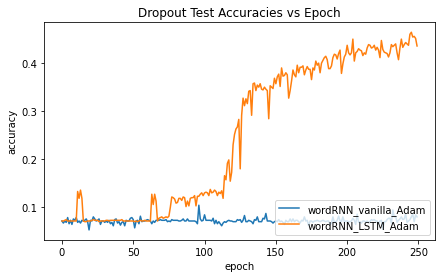

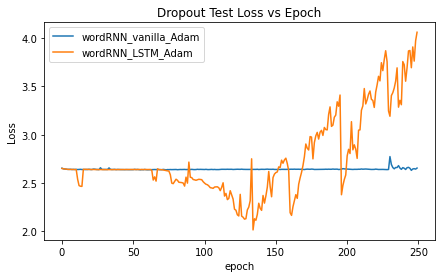

In [20]:
plt.figure(figsize=(7,4))
plt.plot(histories['wordRNN_vanilla_Adam']['test_acc'])
plt.plot(histories['wordRNN_LSTM_Adam']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['wordRNN_vanilla_Adam','wordRNN_LSTM_Adam'], loc='lower right')

plt.savefig(
    f'./results/partB_qn6_wordRNN_0.5_Adam_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['wordRNN_vanilla_Adam']['test_loss'])
plt.plot(histories['wordRNN_LSTM_Adam']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['wordRNN_vanilla_Adam','wordRNN_LSTM_Adam'], loc='upper left')

plt.savefig(
    f'./results/partB_qn6_wordRNN_0.5_Adam_loss.pdf'
)

In [21]:
import pandas as pd

(pd.DataFrame.from_dict(data=histories, orient='index')
   .to_csv('qn6.csv', header=False))

## b. 2-Layer charRNN 

In [1]:
histories = {}

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt
import time

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [3]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.GRU1 = tf.keras.layers.GRUCell(self.hidden_dim)
        self.GRU2 = tf.keras.layers.GRUCell(self.hidden_dim)
        self.cells = [self.GRU1,self.GRU2]
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            self.cells, unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_Adam_2_layers'] = history

Epoch 1, Loss: 2.6696221828460693, Accuracy: 0.07964285463094711, Test Loss: 2.629481315612793, Test Accuracy: 0.1071428582072258
Epoch 2, Loss: 2.614068031311035, Accuracy: 0.1039285734295845, Test Loss: 2.570962905883789, Test Accuracy: 0.1257142871618271
Epoch 3, Loss: 2.4579226970672607, Accuracy: 0.14696428179740906, Test Loss: 2.3524675369262695, Test Accuracy: 0.1599999964237213
Epoch 4, Loss: 2.228285789489746, Accuracy: 0.20392857491970062, Test Loss: 2.1666324138641357, Test Accuracy: 0.21714285016059875
Epoch 5, Loss: 2.053223133087158, Accuracy: 0.2574999928474426, Test Loss: 1.9287959337234497, Test Accuracy: 0.31857141852378845
Epoch 6, Loss: 1.8045727014541626, Accuracy: 0.3578571379184723, Test Loss: 1.6544655561447144, Test Accuracy: 0.3942857086658478
Epoch 7, Loss: 1.6081591844558716, Accuracy: 0.4310714304447174, Test Loss: 1.500562310218811, Test Accuracy: 0.508571445941925
Epoch 8, Loss: 1.5061463117599487, Accuracy: 0.46982142329216003, Test Loss: 1.4340267181396

Epoch 64, Loss: 0.3663174510002136, Accuracy: 0.8778571486473083, Test Loss: 0.9473502039909363, Test Accuracy: 0.7799999713897705
Epoch 65, Loss: 0.3547174036502838, Accuracy: 0.8782142996788025, Test Loss: 0.9678330421447754, Test Accuracy: 0.7685714364051819
Epoch 66, Loss: 0.40347468852996826, Accuracy: 0.8680357336997986, Test Loss: 1.0440839529037476, Test Accuracy: 0.7699999809265137
Epoch 67, Loss: 0.49574705958366394, Accuracy: 0.8364285826683044, Test Loss: 0.938809871673584, Test Accuracy: 0.7514285445213318
Epoch 68, Loss: 0.4677131772041321, Accuracy: 0.8419643044471741, Test Loss: 0.9555380344390869, Test Accuracy: 0.7528571486473083
Epoch 69, Loss: 0.3970330059528351, Accuracy: 0.8598214387893677, Test Loss: 0.9449141621589661, Test Accuracy: 0.7785714268684387
Epoch 70, Loss: 0.35877111554145813, Accuracy: 0.8799999952316284, Test Loss: 1.0107184648513794, Test Accuracy: 0.7714285850524902
Epoch 71, Loss: 0.336159348487854, Accuracy: 0.8803571462631226, Test Loss: 0.949

Epoch 127, Loss: 0.28620070219039917, Accuracy: 0.9005357027053833, Test Loss: 1.1831989288330078, Test Accuracy: 0.7699999809265137
Epoch 128, Loss: 0.2631765305995941, Accuracy: 0.9125000238418579, Test Loss: 1.1206649541854858, Test Accuracy: 0.7757142782211304
Epoch 129, Loss: 0.23478278517723083, Accuracy: 0.9203571677207947, Test Loss: 1.2367591857910156, Test Accuracy: 0.7757142782211304
Epoch 130, Loss: 0.2970983684062958, Accuracy: 0.8999999761581421, Test Loss: 1.2415598630905151, Test Accuracy: 0.7757142782211304
Epoch 131, Loss: 0.35536518692970276, Accuracy: 0.8819642663002014, Test Loss: 1.116991639137268, Test Accuracy: 0.7814285755157471
Epoch 132, Loss: 0.3515443801879883, Accuracy: 0.8810714483261108, Test Loss: 1.0891354084014893, Test Accuracy: 0.7614285945892334
Epoch 133, Loss: 0.3545742928981781, Accuracy: 0.885357141494751, Test Loss: 1.178115963935852, Test Accuracy: 0.7671428322792053
Epoch 134, Loss: 0.3054618537425995, Accuracy: 0.895714282989502, Test Loss:

Epoch 190, Loss: 0.21677203476428986, Accuracy: 0.9242857098579407, Test Loss: 1.3482950925827026, Test Accuracy: 0.7685714364051819
Epoch 191, Loss: 0.2570016384124756, Accuracy: 0.9123214483261108, Test Loss: 1.1498075723648071, Test Accuracy: 0.7799999713897705
Epoch 192, Loss: 0.2536126971244812, Accuracy: 0.9153571724891663, Test Loss: 1.2384968996047974, Test Accuracy: 0.7842857241630554
Epoch 193, Loss: 0.28647497296333313, Accuracy: 0.9060714244842529, Test Loss: 1.321142554283142, Test Accuracy: 0.7642857432365417
Epoch 194, Loss: 0.2814253270626068, Accuracy: 0.9075000286102295, Test Loss: 1.1677719354629517, Test Accuracy: 0.7614285945892334
Epoch 195, Loss: 0.36507758498191833, Accuracy: 0.8817856907844543, Test Loss: 1.2534996271133423, Test Accuracy: 0.7771428823471069
Epoch 196, Loss: 0.36403560638427734, Accuracy: 0.8864285945892334, Test Loss: 1.1252108812332153, Test Accuracy: 0.7842857241630554
Epoch 197, Loss: 0.2911567986011505, Accuracy: 0.904285728931427, Test Lo

In [4]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.GRU1 = tf.keras.layers.SimpleRNNCell(self.hidden_dim)
        self.GRU2 = tf.keras.layers.SimpleRNNCell(self.hidden_dim)
        self.cells = [self.GRU1,self.GRU2]
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            self.cells, unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_Adam_2_layers_vanilla'] = history

Epoch 1, Loss: 2.7420687675476074, Accuracy: 0.07160714268684387, Test Loss: 2.6350762844085693, Test Accuracy: 0.09714286029338837
Epoch 2, Loss: 2.6523356437683105, Accuracy: 0.09125000238418579, Test Loss: 2.613541603088379, Test Accuracy: 0.1014285683631897
Epoch 3, Loss: 2.6338839530944824, Accuracy: 0.0848214253783226, Test Loss: 2.6117773056030273, Test Accuracy: 0.10857142508029938
Epoch 4, Loss: 2.6071717739105225, Accuracy: 0.11678571254014969, Test Loss: 2.5939369201660156, Test Accuracy: 0.08714285492897034
Epoch 5, Loss: 2.6110141277313232, Accuracy: 0.11535714566707611, Test Loss: 2.594745635986328, Test Accuracy: 0.11857143044471741
Epoch 6, Loss: 2.600757360458374, Accuracy: 0.125, Test Loss: 2.585050582885742, Test Accuracy: 0.10999999940395355
Epoch 7, Loss: 2.5993616580963135, Accuracy: 0.11642856895923615, Test Loss: 2.5809333324432373, Test Accuracy: 0.1128571406006813
Epoch 8, Loss: 2.5891754627227783, Accuracy: 0.12446428835391998, Test Loss: 2.5763299465179443, 

Epoch 64, Loss: 2.621882438659668, Accuracy: 0.09428571164608002, Test Loss: 2.6102445125579834, Test Accuracy: 0.08857142925262451
Epoch 65, Loss: 2.6215200424194336, Accuracy: 0.08821428567171097, Test Loss: 2.607795476913452, Test Accuracy: 0.09571428596973419
Epoch 66, Loss: 2.62546706199646, Accuracy: 0.09446428716182709, Test Loss: 2.611823558807373, Test Accuracy: 0.09000000357627869
Epoch 67, Loss: 2.619849681854248, Accuracy: 0.08714285492897034, Test Loss: 2.608699083328247, Test Accuracy: 0.09714286029338837
Epoch 68, Loss: 2.621163845062256, Accuracy: 0.0925000011920929, Test Loss: 2.615502119064331, Test Accuracy: 0.07999999821186066
Epoch 69, Loss: 2.620720624923706, Accuracy: 0.09535714238882065, Test Loss: 2.6128737926483154, Test Accuracy: 0.09571428596973419
Epoch 70, Loss: 2.6204237937927246, Accuracy: 0.09267856925725937, Test Loss: 2.608632802963257, Test Accuracy: 0.08857142925262451
Epoch 71, Loss: 2.6168527603149414, Accuracy: 0.09767857193946838, Test Loss: 2.6

Epoch 127, Loss: 2.6600708961486816, Accuracy: 0.07160714268684387, Test Loss: 2.647188663482666, Test Accuracy: 0.0714285746216774
Epoch 128, Loss: 2.6618165969848633, Accuracy: 0.07249999791383743, Test Loss: 2.651771068572998, Test Accuracy: 0.0714285746216774
Epoch 129, Loss: 2.665759801864624, Accuracy: 0.07607142627239227, Test Loss: 2.650331735610962, Test Accuracy: 0.07285714149475098
Epoch 130, Loss: 2.6638524532318115, Accuracy: 0.07249999791383743, Test Loss: 2.644608974456787, Test Accuracy: 0.0714285746216774
Epoch 131, Loss: 2.654790163040161, Accuracy: 0.07357142865657806, Test Loss: 2.64286208152771, Test Accuracy: 0.08285713940858841
Epoch 132, Loss: 2.6540892124176025, Accuracy: 0.07374999672174454, Test Loss: 2.6424641609191895, Test Accuracy: 0.07285714149475098
Epoch 133, Loss: 2.6518890857696533, Accuracy: 0.08053571730852127, Test Loss: 2.6371724605560303, Test Accuracy: 0.0714285746216774
Epoch 134, Loss: 2.653286933898926, Accuracy: 0.0771428570151329, Test Los

Epoch 189, Loss: 2.650925397872925, Accuracy: 0.07571428269147873, Test Loss: 2.6261870861053467, Test Accuracy: 0.09571428596973419
Epoch 190, Loss: 2.6597325801849365, Accuracy: 0.07196428626775742, Test Loss: 2.6481423377990723, Test Accuracy: 0.0714285746216774
Epoch 191, Loss: 2.662013053894043, Accuracy: 0.07374999672174454, Test Loss: 2.643362283706665, Test Accuracy: 0.0714285746216774
Epoch 192, Loss: 2.6627402305603027, Accuracy: 0.07303571701049805, Test Loss: 2.6451680660247803, Test Accuracy: 0.0714285746216774
Epoch 193, Loss: 2.6553285121917725, Accuracy: 0.07053571194410324, Test Loss: 2.644261598587036, Test Accuracy: 0.0714285746216774
Epoch 194, Loss: 2.6608312129974365, Accuracy: 0.07053571194410324, Test Loss: 2.6411001682281494, Test Accuracy: 0.0714285746216774
Epoch 195, Loss: 2.6613595485687256, Accuracy: 0.06714285910129547, Test Loss: 2.643688917160034, Test Accuracy: 0.08428571373224258
Epoch 196, Loss: 2.6643218994140625, Accuracy: 0.06607142835855484, Test

In [5]:
# Build model
tf.keras.backend.set_floatx('float32')

class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.GRU1 = tf.keras.layers.LSTMCell(self.hidden_dim)
        self.GRU2 = tf.keras.layers.LSTMCell(self.hidden_dim)
        self.cells = [self.GRU1,self.GRU2]
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            self.cells, unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        #print(x.shape)
        encoding = self.rnn(x)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = CharRNN(256,HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['charRNN_Adam_2_layers_LSTM'] = history

Epoch 1, Loss: 2.655040979385376, Accuracy: 0.08535714447498322, Test Loss: 2.6038663387298584, Test Accuracy: 0.1071428582072258
Epoch 2, Loss: 2.6272213459014893, Accuracy: 0.10321428626775742, Test Loss: 2.6450700759887695, Test Accuracy: 0.07285714149475098
Epoch 3, Loss: 2.6374661922454834, Accuracy: 0.08321428298950195, Test Loss: 2.6104061603546143, Test Accuracy: 0.09142857044935226
Epoch 4, Loss: 2.626201868057251, Accuracy: 0.08660714328289032, Test Loss: 2.6040918827056885, Test Accuracy: 0.09857142716646194
Epoch 5, Loss: 2.624950885772705, Accuracy: 0.09767857193946838, Test Loss: 2.6395421028137207, Test Accuracy: 0.04285714402794838
Epoch 6, Loss: 2.6468799114227295, Accuracy: 0.06750000268220901, Test Loss: 2.6413581371307373, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.6453652381896973, Accuracy: 0.05982142686843872, Test Loss: 2.640082359313965, Test Accuracy: 0.06714285910129547
Epoch 8, Loss: 2.6443588733673096, Accuracy: 0.06750000268220901, Test Loss: 2.640

Epoch 64, Loss: 1.2548770904541016, Accuracy: 0.5285714268684387, Test Loss: 1.333609700202942, Test Accuracy: 0.49000000953674316
Epoch 65, Loss: 1.2267554998397827, Accuracy: 0.5407142639160156, Test Loss: 1.2705055475234985, Test Accuracy: 0.5214285850524902
Epoch 66, Loss: 1.213518500328064, Accuracy: 0.5505357384681702, Test Loss: 1.2914708852767944, Test Accuracy: 0.5142857432365417
Epoch 67, Loss: 1.2098362445831299, Accuracy: 0.5514285564422607, Test Loss: 1.2550491094589233, Test Accuracy: 0.5314285755157471
Epoch 68, Loss: 1.1983720064163208, Accuracy: 0.5475000143051147, Test Loss: 1.2519694566726685, Test Accuracy: 0.5371428728103638
Epoch 69, Loss: 1.169811725616455, Accuracy: 0.5639285445213318, Test Loss: 1.243645429611206, Test Accuracy: 0.5657142996788025
Epoch 70, Loss: 1.1847071647644043, Accuracy: 0.558571457862854, Test Loss: 1.2408711910247803, Test Accuracy: 0.5328571200370789
Epoch 71, Loss: 1.1548196077346802, Accuracy: 0.5641071200370789, Test Loss: 1.21156489

Epoch 127, Loss: 0.6656894087791443, Accuracy: 0.7660714387893677, Test Loss: 1.0624747276306152, Test Accuracy: 0.6899999976158142
Epoch 128, Loss: 0.5979902744293213, Accuracy: 0.7817857265472412, Test Loss: 1.0388611555099487, Test Accuracy: 0.704285740852356
Epoch 129, Loss: 0.6236570477485657, Accuracy: 0.7705357074737549, Test Loss: 1.0705162286758423, Test Accuracy: 0.6871428489685059
Epoch 130, Loss: 0.668056309223175, Accuracy: 0.7646428346633911, Test Loss: 1.0532835721969604, Test Accuracy: 0.6885714530944824
Epoch 131, Loss: 0.8307888507843018, Accuracy: 0.7198214530944824, Test Loss: 1.0427416563034058, Test Accuracy: 0.704285740852356
Epoch 132, Loss: 0.6664899587631226, Accuracy: 0.7628571391105652, Test Loss: 0.9419615864753723, Test Accuracy: 0.7114285826683044
Epoch 133, Loss: 0.6177552938461304, Accuracy: 0.7794643044471741, Test Loss: 0.9886898398399353, Test Accuracy: 0.7085714340209961
Epoch 134, Loss: 0.6256271004676819, Accuracy: 0.7767857313156128, Test Loss: 0

Epoch 190, Loss: 0.39153850078582764, Accuracy: 0.8607142567634583, Test Loss: 1.5306605100631714, Test Accuracy: 0.7228571176528931
Epoch 191, Loss: 0.7619268894195557, Accuracy: 0.7724999785423279, Test Loss: 1.0264168977737427, Test Accuracy: 0.7171428799629211
Epoch 192, Loss: 0.5811828970909119, Accuracy: 0.8069642782211304, Test Loss: 1.0272296667099, Test Accuracy: 0.7300000190734863
Epoch 193, Loss: 0.47814857959747314, Accuracy: 0.8382142782211304, Test Loss: 1.1034868955612183, Test Accuracy: 0.7471428513526917
Epoch 194, Loss: 0.43222305178642273, Accuracy: 0.8510714173316956, Test Loss: 1.1781164407730103, Test Accuracy: 0.7400000095367432
Epoch 195, Loss: 0.415357381105423, Accuracy: 0.8539285659790039, Test Loss: 1.1403454542160034, Test Accuracy: 0.7371428608894348
Epoch 196, Loss: 0.377754807472229, Accuracy: 0.8658928275108337, Test Loss: 1.2479612827301025, Test Accuracy: 0.7442857027053833
Epoch 197, Loss: 0.4002327620983124, Accuracy: 0.8578571677207947, Test Loss: 

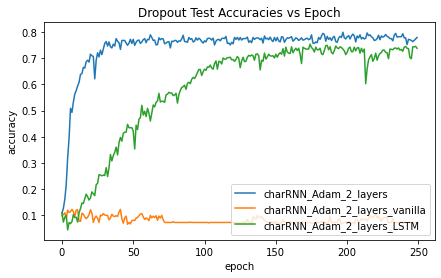

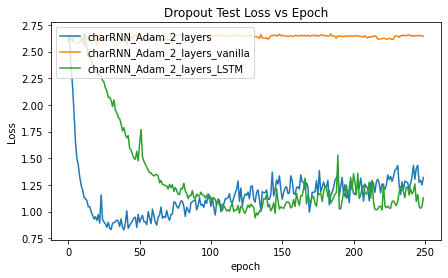

In [6]:
plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_Adam_2_layers']['test_acc'])
plt.plot(histories['charRNN_Adam_2_layers_vanilla']['test_acc'])
plt.plot(histories['charRNN_Adam_2_layers_LSTM']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['charRNN_Adam_2_layers','charRNN_Adam_2_layers_vanilla','charRNN_Adam_2_layers_LSTM'], loc='lower right')

plt.savefig(
    f'./results/partB_qn6_charRNN_Adam_2_layers_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['charRNN_Adam_2_layers']['test_loss'])
plt.plot(histories['charRNN_Adam_2_layers_vanilla']['test_loss'])
plt.plot(histories['charRNN_Adam_2_layers_LSTM']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['charRNN_Adam_2_layers','charRNN_Adam_2_layers_vanilla','charRNN_Adam_2_layers_LSTM'], loc='upper left')

plt.savefig(
    f'./results/partB_qn6_charRNN_Adam_2_layers_loss.pdf'
)

## b. wordRNN 2-Layers

In [7]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import nltk

nltk.download('punkt')

MAX_DOCUMENT_LENGTH = 100
EMBEDDING_SIZE = 20
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)


def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[nltk_data] Downloading package punkt to C:\Users\Shearman
[nltk_data]     Chua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.GRU1 = tf.keras.layers.GRUCell(self.hidden_dim)
        self.GRU2 = tf.keras.layers.GRUCell(self.hidden_dim)
        self.cells = [self.GRU1,self.GRU2]
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            self.cells, unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_GRU_2_layers'] = history

Epoch 1, Loss: 2.6783735752105713, Accuracy: 0.07107143104076385, Test Loss: 2.651365041732788, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6581368446350098, Accuracy: 0.0758928582072258, Test Loss: 2.6481921672821045, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.652409553527832, Accuracy: 0.06660714000463486, Test Loss: 2.644259452819824, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6473467350006104, Accuracy: 0.06964285671710968, Test Loss: 2.617936372756958, Test Accuracy: 0.13428571820259094
Epoch 5, Loss: 2.2935292720794678, Accuracy: 0.1569642871618271, Test Loss: 1.9650715589523315, Test Accuracy: 0.23999999463558197
Epoch 6, Loss: 1.749202847480774, Accuracy: 0.2641071379184723, Test Loss: 1.5839567184448242, Test Accuracy: 0.3199999928474426
Epoch 7, Loss: 1.4607654809951782, Accuracy: 0.3512499928474426, Test Loss: 1.4349340200424194, Test Accuracy: 0.38999998569488525
Epoch 8, Loss: 1.1516764163970947, Accuracy: 0.47232142090797424, Test Loss: 1.2019304037

Epoch 64, Loss: 0.055506110191345215, Accuracy: 0.9789285659790039, Test Loss: 0.978920042514801, Test Accuracy: 0.8357142806053162
Epoch 65, Loss: 0.04303665831685066, Accuracy: 0.9851785898208618, Test Loss: 1.0392261743545532, Test Accuracy: 0.8371428847312927
Epoch 66, Loss: 0.039061177521944046, Accuracy: 0.9878571629524231, Test Loss: 1.079331398010254, Test Accuracy: 0.8357142806053162
Epoch 67, Loss: 0.03818023204803467, Accuracy: 0.9862499833106995, Test Loss: 1.1341830492019653, Test Accuracy: 0.8342857360839844
Epoch 68, Loss: 0.03931490704417229, Accuracy: 0.9848214387893677, Test Loss: 1.1502101421356201, Test Accuracy: 0.8385714292526245
Epoch 69, Loss: 0.039998091757297516, Accuracy: 0.9842857122421265, Test Loss: 1.1988874673843384, Test Accuracy: 0.8328571319580078
Epoch 70, Loss: 0.036595843732357025, Accuracy: 0.9866071343421936, Test Loss: 1.256113886833191, Test Accuracy: 0.8271428346633911
Epoch 71, Loss: 0.08230677247047424, Accuracy: 0.9748214483261108, Test Los

Epoch 126, Loss: 0.03841488063335419, Accuracy: 0.9862499833106995, Test Loss: 0.9295970797538757, Test Accuracy: 0.8528571724891663
Epoch 127, Loss: 0.03941884636878967, Accuracy: 0.9871428608894348, Test Loss: 0.9397783279418945, Test Accuracy: 0.8585714101791382
Epoch 128, Loss: 0.030163027346134186, Accuracy: 0.9889285564422607, Test Loss: 1.0014480352401733, Test Accuracy: 0.8557142615318298
Epoch 129, Loss: 0.032468728721141815, Accuracy: 0.9878571629524231, Test Loss: 1.0792752504348755, Test Accuracy: 0.8500000238418579
Epoch 130, Loss: 0.029205836355686188, Accuracy: 0.9891071319580078, Test Loss: 1.0367217063903809, Test Accuracy: 0.8585714101791382
Epoch 131, Loss: 0.02916988730430603, Accuracy: 0.9898214340209961, Test Loss: 1.0400408506393433, Test Accuracy: 0.8557142615318298
Epoch 132, Loss: 0.03289581835269928, Accuracy: 0.9883928298950195, Test Loss: 1.0472755432128906, Test Accuracy: 0.8614285588264465
Epoch 133, Loss: 0.02984187752008438, Accuracy: 0.9908928275108337

Epoch 188, Loss: 0.0794324055314064, Accuracy: 0.9778571724891663, Test Loss: 1.1032894849777222, Test Accuracy: 0.8485714197158813
Epoch 189, Loss: 0.09058072417974472, Accuracy: 0.9739285707473755, Test Loss: 1.07194185256958, Test Accuracy: 0.8299999833106995
Epoch 190, Loss: 0.07465515285730362, Accuracy: 0.9783928394317627, Test Loss: 0.9791781306266785, Test Accuracy: 0.8500000238418579
Epoch 191, Loss: 0.08886223286390305, Accuracy: 0.9755356907844543, Test Loss: 1.041953682899475, Test Accuracy: 0.845714271068573
Epoch 192, Loss: 0.07335514575242996, Accuracy: 0.9785714149475098, Test Loss: 1.0225063562393188, Test Accuracy: 0.8514285683631897
Epoch 193, Loss: 0.06322651356458664, Accuracy: 0.9826785922050476, Test Loss: 1.0225719213485718, Test Accuracy: 0.8471428751945496
Epoch 194, Loss: 0.05164618417620659, Accuracy: 0.9825000166893005, Test Loss: 1.0306603908538818, Test Accuracy: 0.8471428751945496
Epoch 195, Loss: 0.03588492050766945, Accuracy: 0.9883928298950195, Test L

Epoch 250, Loss: 0.05016082152724266, Accuracy: 0.9819642901420593, Test Loss: 1.3414549827575684, Test Accuracy: 0.8257142901420593


In [9]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.cell1 = tf.keras.layers.SimpleRNNCell(self.hidden_dim)
        self.cell2 = tf.keras.layers.SimpleRNNCell(self.hidden_dim)
        self.cells = [self.cell1,self.cell2]
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            self.cells, unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_vanilla_2_layers'] = history

Epoch 1, Loss: 2.7013494968414307, Accuracy: 0.06535714119672775, Test Loss: 2.6557979583740234, Test Accuracy: 0.08285713940858841
Epoch 2, Loss: 2.6563055515289307, Accuracy: 0.07892857491970062, Test Loss: 2.650999069213867, Test Accuracy: 0.07000000029802322
Epoch 3, Loss: 2.645594358444214, Accuracy: 0.08339285850524902, Test Loss: 2.6458165645599365, Test Accuracy: 0.10999999940395355
Epoch 4, Loss: 2.621812582015991, Accuracy: 0.09535714238882065, Test Loss: 2.6516199111938477, Test Accuracy: 0.07999999821186066
Epoch 5, Loss: 2.617952585220337, Accuracy: 0.08107142895460129, Test Loss: 2.6548938751220703, Test Accuracy: 0.07999999821186066
Epoch 6, Loss: 2.7762186527252197, Accuracy: 0.0701785683631897, Test Loss: 2.6741912364959717, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.680229425430298, Accuracy: 0.07678571343421936, Test Loss: 2.6542046070098877, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.6722450256347656, Accuracy: 0.06857142597436905, Test Loss: 2.65066

Epoch 64, Loss: 2.6467721462249756, Accuracy: 0.07803571224212646, Test Loss: 2.6194753646850586, Test Accuracy: 0.08571428805589676
Epoch 65, Loss: 2.646552562713623, Accuracy: 0.08267857134342194, Test Loss: 2.614713191986084, Test Accuracy: 0.08571428805589676
Epoch 66, Loss: 2.641242504119873, Accuracy: 0.07678571343421936, Test Loss: 2.6207244396209717, Test Accuracy: 0.09714286029338837
Epoch 67, Loss: 2.6454806327819824, Accuracy: 0.07839285582304001, Test Loss: 2.6135060787200928, Test Accuracy: 0.09142857044935226
Epoch 68, Loss: 2.6427383422851562, Accuracy: 0.08392857015132904, Test Loss: 2.616657257080078, Test Accuracy: 0.10428571701049805
Epoch 69, Loss: 2.6475279331207275, Accuracy: 0.0860714316368103, Test Loss: 2.610889196395874, Test Accuracy: 0.08857142925262451
Epoch 70, Loss: 2.64331316947937, Accuracy: 0.08071428537368774, Test Loss: 2.621638298034668, Test Accuracy: 0.09142857044935226
Epoch 71, Loss: 2.6394786834716797, Accuracy: 0.08714285492897034, Test Loss: 

Epoch 126, Loss: 2.6592555046081543, Accuracy: 0.07285714149475098, Test Loss: 2.6619772911071777, Test Accuracy: 0.07999999821186066
Epoch 127, Loss: 2.656797409057617, Accuracy: 0.07285714149475098, Test Loss: 2.6453418731689453, Test Accuracy: 0.07999999821186066
Epoch 128, Loss: 2.6552703380584717, Accuracy: 0.0726785734295845, Test Loss: 2.6630096435546875, Test Accuracy: 0.0771428570151329
Epoch 129, Loss: 2.654163122177124, Accuracy: 0.07357142865657806, Test Loss: 2.63973069190979, Test Accuracy: 0.08285713940858841
Epoch 130, Loss: 2.6524083614349365, Accuracy: 0.07696428894996643, Test Loss: 2.6448748111724854, Test Accuracy: 0.06714285910129547
Epoch 131, Loss: 2.647275924682617, Accuracy: 0.08642856776714325, Test Loss: 2.6525893211364746, Test Accuracy: 0.08142857253551483
Epoch 132, Loss: 2.6499030590057373, Accuracy: 0.07660714536905289, Test Loss: 2.65024995803833, Test Accuracy: 0.07428571581840515
Epoch 133, Loss: 2.6577045917510986, Accuracy: 0.07642856985330582, Tes

Epoch 188, Loss: 2.6503095626831055, Accuracy: 0.07553571462631226, Test Loss: 2.658543825149536, Test Accuracy: 0.07285714149475098
Epoch 189, Loss: 2.653897285461426, Accuracy: 0.08089285343885422, Test Loss: 2.642948865890503, Test Accuracy: 0.08285713940858841
Epoch 190, Loss: 2.6506497859954834, Accuracy: 0.0860714316368103, Test Loss: 2.6395318508148193, Test Accuracy: 0.08285713940858841
Epoch 191, Loss: 2.648064613342285, Accuracy: 0.08500000089406967, Test Loss: 2.656693458557129, Test Accuracy: 0.07999999821186066
Epoch 192, Loss: 2.6491944789886475, Accuracy: 0.07839285582304001, Test Loss: 2.6425158977508545, Test Accuracy: 0.0771428570151329
Epoch 193, Loss: 2.645904302597046, Accuracy: 0.07803571224212646, Test Loss: 2.648587942123413, Test Accuracy: 0.0771428570151329
Epoch 194, Loss: 2.646357536315918, Accuracy: 0.0803571417927742, Test Loss: 2.6496422290802, Test Accuracy: 0.0771428570151329
Epoch 195, Loss: 2.6472489833831787, Accuracy: 0.08214285969734192, Test Loss:

Epoch 250, Loss: 2.661403179168701, Accuracy: 0.06964285671710968, Test Loss: 2.6408536434173584, Test Accuracy: 0.07857143133878708


In [10]:
# Build model
tf.keras.backend.set_floatx('float32')
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.cell1 = tf.keras.layers.LSTMCell(self.hidden_dim)
        self.cell2 = tf.keras.layers.LSTMCell(self.hidden_dim)
        self.cells = [self.cell1,self.cell2]
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            self.cells, unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)

        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

model = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

train_acc = []
train_ls = []
test_acc = []
test_ls = []

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    train_acc.append(train_accuracy.result())
    train_ls.append(train_loss.result())
    test_acc.append(test_accuracy.result())
    test_ls.append(test_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
history = {}
history['train_acc'] = train_acc
history['train_loss'] = train_ls
history['test_acc'] = test_acc
history['test_loss'] = test_ls
histories['wordRNN_LSTM_2_layers'] = history

Epoch 1, Loss: 2.6851415634155273, Accuracy: 0.06732142716646194, Test Loss: 2.658841133117676, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6601529121398926, Accuracy: 0.0694642886519432, Test Loss: 2.6476378440856934, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.655489683151245, Accuracy: 0.0714285746216774, Test Loss: 2.6480624675750732, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.649746894836426, Accuracy: 0.0726785734295845, Test Loss: 2.6438004970550537, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.648172378540039, Accuracy: 0.06607142835855484, Test Loss: 2.6433804035186768, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.648186683654785, Accuracy: 0.06785714626312256, Test Loss: 2.6417059898376465, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.6441996097564697, Accuracy: 0.07374999672174454, Test Loss: 2.6411807537078857, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.6449131965637207, Accuracy: 0.06839285790920258, Test Loss: 2.640994787216

Epoch 64, Loss: 0.16642098128795624, Accuracy: 0.9571428298950195, Test Loss: 1.716006875038147, Test Accuracy: 0.7685714364051819
Epoch 65, Loss: 0.13072754442691803, Accuracy: 0.9619643092155457, Test Loss: 1.8390775918960571, Test Accuracy: 0.7628571391105652
Epoch 66, Loss: 0.12607161700725555, Accuracy: 0.9637500047683716, Test Loss: 1.8191670179367065, Test Accuracy: 0.7614285945892334
Epoch 67, Loss: 0.12909875810146332, Accuracy: 0.9642857313156128, Test Loss: 1.7951680421829224, Test Accuracy: 0.7714285850524902
Epoch 68, Loss: 0.14858762919902802, Accuracy: 0.9607142806053162, Test Loss: 1.9467519521713257, Test Accuracy: 0.758571445941925
Epoch 69, Loss: 0.18946833908557892, Accuracy: 0.9516071677207947, Test Loss: 1.6366678476333618, Test Accuracy: 0.7657142877578735
Epoch 70, Loss: 0.1715361475944519, Accuracy: 0.9585714340209961, Test Loss: 2.3538854122161865, Test Accuracy: 0.727142870426178
Epoch 71, Loss: 0.22174280881881714, Accuracy: 0.9471428394317627, Test Loss: 1.

Epoch 127, Loss: 0.1291361004114151, Accuracy: 0.9694643020629883, Test Loss: 1.8014343976974487, Test Accuracy: 0.7928571701049805
Epoch 128, Loss: 0.11832115054130554, Accuracy: 0.9733928442001343, Test Loss: 1.876606822013855, Test Accuracy: 0.7857142686843872
Epoch 129, Loss: 0.10718128085136414, Accuracy: 0.9748214483261108, Test Loss: 1.8448190689086914, Test Accuracy: 0.7799999713897705
Epoch 130, Loss: 0.18174996972084045, Accuracy: 0.9573214054107666, Test Loss: 1.670362114906311, Test Accuracy: 0.7685714364051819
Epoch 131, Loss: 0.14624518156051636, Accuracy: 0.9635714292526245, Test Loss: 1.7234946489334106, Test Accuracy: 0.7714285850524902
Epoch 132, Loss: 0.1300520896911621, Accuracy: 0.9676785469055176, Test Loss: 1.7980560064315796, Test Accuracy: 0.7799999713897705
Epoch 133, Loss: 0.11650275439023972, Accuracy: 0.9714285731315613, Test Loss: 1.994533658027649, Test Accuracy: 0.7671428322792053
Epoch 134, Loss: 0.14724098145961761, Accuracy: 0.9635714292526245, Test L

Epoch 190, Loss: 0.2418510913848877, Accuracy: 0.939464271068573, Test Loss: 2.064061403274536, Test Accuracy: 0.704285740852356
Epoch 191, Loss: 0.30360451340675354, Accuracy: 0.9267857074737549, Test Loss: 2.07757830619812, Test Accuracy: 0.6971428394317627
Epoch 192, Loss: 0.3026898503303528, Accuracy: 0.9267857074737549, Test Loss: 1.91729736328125, Test Accuracy: 0.704285740852356
Epoch 193, Loss: 0.3034168481826782, Accuracy: 0.9266071319580078, Test Loss: 2.1463022232055664, Test Accuracy: 0.6985714435577393
Epoch 194, Loss: 0.9706793427467346, Accuracy: 0.783214271068573, Test Loss: 2.5220935344696045, Test Accuracy: 0.5
Epoch 195, Loss: 1.8365566730499268, Accuracy: 0.5257142782211304, Test Loss: 1.7860091924667358, Test Accuracy: 0.5242857336997986
Epoch 196, Loss: 1.3678447008132935, Accuracy: 0.583214282989502, Test Loss: 1.5655730962753296, Test Accuracy: 0.5299999713897705
Epoch 197, Loss: 1.1380829811096191, Accuracy: 0.6255357265472412, Test Loss: 1.6205676794052124, Te

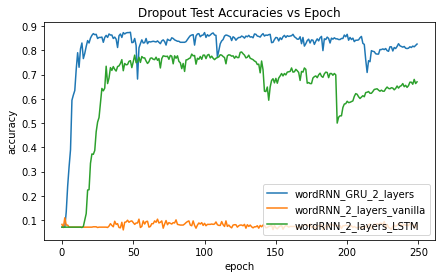

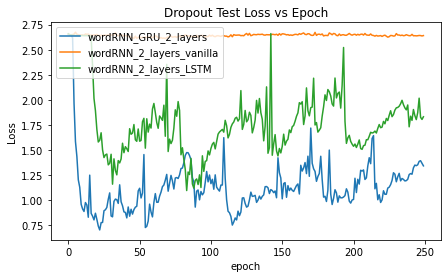

In [11]:
plt.figure(figsize=(7,4))
plt.plot(histories['wordRNN_GRU_2_layers']['test_acc'])
plt.plot(histories['wordRNN_vanilla_2_layers']['test_acc'])
plt.plot(histories['wordRNN_LSTM_2_layers']['test_acc'])
plt.title('Dropout Test Accuracies vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['wordRNN_GRU_2_layers','wordRNN_2_layers_vanilla','wordRNN_2_layers_LSTM'], loc='lower right')

plt.savefig(
    f'./results/partB_qn6_wordRNN_Adam_2_layers_accuracies.pdf'
)

plt.figure(figsize=(7,4))
plt.plot(histories['wordRNN_GRU_2_layers']['test_loss'])
plt.plot(histories['wordRNN_vanilla_2_layers']['test_loss'])
plt.plot(histories['wordRNN_LSTM_2_layers']['test_loss'])
plt.title('Dropout Test Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['wordRNN_GRU_2_layers','wordRNN_2_layers_vanilla','wordRNN_2_layers_LSTM'], loc='upper left')

plt.savefig(
    f'./results/partB_qn6_wordRNN_Adam_2_layers_loss.pdf'
)